## Abstract:  (1page)
1. Problem general: MSA 
2. Related work & SOTA: heuristics tal Zhang's DQN 
3. problem specific: problems of DQN and of DQN for MSA (speed of convergence, etc.)
4. objectif: mitigate/solve that problem
5. Methods: Prioritized experience replay (DQN), why ? (theoretical justification)
6. Results: reward o speed li kherjo lina (b code Open-source)
7. Conclusion: P-DQN ma mselkch f had domaine, malgré mselek f la majorité des autres domaines


## Introduction:  (3page)

1. Problem general
2. SOTA
3. problem specific
4. objectif

## Methods  (5page)



## Results   (3page)



## Discussion  (2page)
* ay experiment secondaires
* ga3 hyperparamaeters (alpha etc. li essayina)
* graph o commentaires

## Conclusion  (1page)


## Refs  (2page)

In [ ]:
17 pages

In [1]:
import config
from env import Environment
from models import Encoder

In [2]:
import torch
import torch.nn as nn
import numpy as np
import random
import os
from collections import deque

In [4]:
class PrioritizedReplayMemory:
    def __init__(self, capacity, alpha=0.6, beta=0.4, beta_increment_per_sampling=0.001):
        self.capacity = capacity
        self.alpha = alpha
        self.beta = beta
        self.beta_increment_per_sampling = beta_increment_per_sampling
        self.buffer = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)
        self.max_priority = 1.0

    def push(self, transition):
        self.buffer.append(transition)
        self.priorities.append(self.max_priority)

    def sample(self, batch_size):
        priorities = np.array(self.priorities)
        probabilities = priorities ** self.alpha
        probabilities /= probabilities.sum()
        
        indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)
        samples = [self.buffer[index] for index in indices]

        weights = (len(self.buffer) * probabilities[indices]) ** (-self.beta)
        weights /= weights.max()
        self.beta = min(1.0, self.beta + self.beta_increment_per_sampling)

        state, next_state, action, reward, done = [], [], [], [], []

        for i in range(batch_size):
            s, ns, a, r, d = samples[i]
            state.append(s)
            next_state.append(ns)
            action.append(a)
            reward.append(r)
            done.append(d)

        return state, next_state, action, reward, done, indices, weights

    def update_priorities(self, indices, errors, epsilon=1e-6):
        for index, error in zip(indices, errors):
            priority = abs(error) + epsilon
            self.priorities[index] = priority
            self.max_priority = max(self.max_priority, priority)

    def __len__(self):
        return len(self.buffer)

    @property
    def size(self):
        return len(self.buffer)


In [5]:
class Net(nn.Module):
    """docstring for Net"""

    def __init__(self, seq_num, max_seq_len, action_number, max_value, d_model=64):
        super(Net, self).__init__()
        self.max_value = max_value
        dim = seq_num * (max_seq_len + 1)
        # layers:
        self.encoder = Encoder(6, d_model, dim)
        self.dropout = nn.Dropout()
        self.l1 = nn.Linear(dim * d_model, 1028)
        self.f1 = nn.LeakyReLU()
        self.l2 = nn.Linear(1028, 512)
        self.f2 = nn.LeakyReLU()
        self.l3 = nn.Linear(512, action_number)
        self.f3 = nn.Tanh()

        self.mask = lambda x, y: (x != y).unsqueeze(-2)

    def forward(self, x):
        x = self.encoder(x, self.mask(x, 0))
        # x = self.dropout(x)
        x = x.view(x.size()[0], -1)
        x = self.f1(self.l1(x))
        x = self.f2(self.l2(x))
        x = self.f3(self.l3(x))
        x = torch.mul(x, self.max_value)

        return x


class DQN_PER:
    def __init__(self, action_number, seq_num, max_seq_len, max_value):
        super(DQN_PER, self).__init__()
        self.seq_num = seq_num
        self.max_seq_len = max_seq_len
        self.action_number = action_number

        self.eval_net = Net(seq_num, max_seq_len, action_number, max_value).to(config.device)
        self.target_net = Net(seq_num, max_seq_len, action_number, max_value).to(config.device)

        self.current_epsilon = config.epsilon

        self.update_step_counter = 0
        self.epsilon_step_counter = 0

        self.replay_memory = PrioritizedReplayMemory(config.replay_memory_size, config.alpha)
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=config.alpha)
        self.loss_func = nn.SmoothL1Loss()

    def update_epsilon(self):
        self.epsilon_step_counter += 1
        if self.epsilon_step_counter % config.decrement_iteration == 0:
            self.current_epsilon = max(0, self.current_epsilon - config.delta)

    def select(self, state):
        if random.random() <= self.current_epsilon:
            action = np.random.randint(0, self.action_number)
        else:
            action_val = self.eval_net.forward(torch.LongTensor(state).unsqueeze_(0).to(config.device))
            action = torch.argmax(action_val, 1).cpu().data.numpy()[0]

        return action

    def predict(self, state):
        action_val = self.eval_net.forward(torch.LongTensor(state).unsqueeze_(0).to(config.device))
        return torch.argmax(action_val, 1).cpu().data.numpy()[0]

    def update(self):
        self.update_step_counter += 1
        if self.update_step_counter % config.update_iteration == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())

        if self.replay_memory.size < config.batch_size:
            return

        state, next_state, action, reward, done, indices, weights = self.replay_memory.sample(config.batch_size)

        batch_state = torch.LongTensor(state).to(config.device)
        batch_next_state = torch.LongTensor(next_state).to(config.device)
        batch_action = torch.LongTensor(action).to(config.device)
        batch_reward = torch.FloatTensor(reward).to(config.device)
        batch_done = torch.FloatTensor(done).to(config.device)
        batch_weights = torch.FloatTensor(weights).to(config.device)

        q_eval = self.eval_net(batch_state).gather(1, batch_action.unsqueeze_(-1)).squeeze_(1).to(config.device)

        q_next = self.target_net(batch_next_state).max(1)[0].to(config.device).detach_()
        q_target = batch_reward + batch_done * config.gamma * q_next

        loss = self.loss_func(q_eval, q_target)
        loss = (loss * batch_weights).mean()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update priorities
        errors = torch.abs(q_target - q_eval).detach().cpu().numpy()
        self.replay_memory.update_priorities(indices, errors)

    def save(self, filename, path=config.weight_path):
        torch.save(self.eval_net.state_dict(), os.path.join(path, "{}.pth".format(filename)))
        print("{} has been saved...".format(filename))
   
    def load(self, filename, path=config.weight_path):
        self.eval_net.load_state_dict(torch.load(os.path.join(path, "{}.pth".format(filename))))
        self.target_net.load_state_dict(self.eval_net.state_dict())
        print("{} has been loaded...".format(filename))



# testing to understand --------------------------------------------------------------

In [14]:
## dataset_0
# seqs = ['ACCAGCGGGTTGCCGACGTAGCAGATA',
#  'GCACTGTTGTTCCACGCATAGACA',
#  'ACACCGTGGGTTCTCGACGGAGTGACA',
#  'ACGAGGTGGGCGTTCCGACCAGGGAGGCC',
#  'TACGGGGGTTTCCGACGAGCAGACA']


# dataset_3
seqs = ["CACGTGGGCCGATCTAGAGACCGGTGGGGGGG",
    "ACGACGGCATCTAGAGACCGGTGATGGG",
    "CACGAGGATCTAGAGACGCGGTGATGTG",
    "CACGAGGCGATCTAGAACCGGTGATGTG",
    "CACGAGGCGATCTGAGGCCGGTGATGGT"
]

# dataset_9
seqs = [
    "GACGAGACTGGCATTATTCCTCGAA",
    "GACGAGACCGGCAATATTCCTCGAA",
    "GACGAGACCGGCAATATTCCTCCAA",
    "GACGAGACCGGTAATATTCCTCGCCA",
    "GGCGAGACCGGAATATTTCTCTCGTA"
]

env = Environment(seqs)

In [15]:
env.action_number

31

In [16]:
env.row

5

In [17]:
env.max_len  #this is what changes wrt each list of seqs, that's why we must instanciate a new env and model each time

26

In [32]:
env.max_reward

40.0

In [14]:
dqn_per = DQN_PER(env.action_number, env.row, env.max_len, env.max_len * env.max_reward)

In [15]:
# dqn_per.eval_net

In [16]:
print(sum(p.numel() for p in dqn_per.eval_net.parameters())/1e6, 'M parameters')  

10.455203 M parameters


In [17]:
import dataset3
import dataset4
import dataset5
import dataset6

In [18]:
dataset = dataset5

In [19]:
start= 0
end= 25   #for comparison with zhang

for index, name in enumerate(dataset.datasets[start:end if end != -1 else len(dataset.datasets)], start):
    if not hasattr(dataset, name):
        continue
    seqs = getattr(dataset, name)
#     print(seqs)
    print(index)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


# ----------------------------------------------------------------------------------------------------

# Now the training fct

* This trains the model for one list of sequences (i.e., seqs) for max_episode

In [40]:
def train(seqs, index):
    # here we make a new agent and a new env for each seqs to train and evaluate seperately 
    # --------------------------------------------------------------------------------------
    env = Environment(seqs)
    dqn_per = DQN_PER(env.action_number, env.row, env.max_len, env.max_len * env.max_reward)
    # -------------------------------------------------------------------------------------
    total_steps = 0
    rs = []
    for episode in range(config.max_episode):
        state = env.reset()
        episode_reward = 0
        while True:
            action = dqn_per.select(state)
            reward, next_state, done = env.step(action)
            
            transition = (state, next_state, action, reward, done)
            dqn_per.replay_memory.push(transition)
            dqn_per.update()

            state = next_state
            episode_reward += reward
            total_steps += 1

            if done:
                break
        
        rs.append(episode_reward)
        
        dqn_per.update_epsilon()
        dqn_per.update()
        
        if episode % 1000 == 0:
            print('---------- trainining reached episode nbr:', episode)
            print('---------- reward for this episode = ', episode_reward)
            
    print("done training for this sequence of index: ", index)
    print("Episode: {}, Reward: {}, Epsilon: {:.4f}".format(episode, episode_reward, dqn_per.current_epsilon))
    
    # here you will save 25 model, each for the corresponding dataset
    fname = 'my_dqn_per_' + str(index) + '_'
    dqn_per.save(fname)
    # --------------------------------------------------------------
    
    print("done saving also for this sequence of index: ", index)
    print("\n\n")
    
    return rs

In [41]:
# below code for one seqs list (6000 episodes) takes about  ~1h30min 

### Call the train fct inside a loop for every seqs in the dataset

In [ ]:
import datetime
now = datetime.datetime.now()
print("----------- began at : ", now.time(), "--------------------\n")


start= 0
end= 25  #25 for comparison with zhang,  -1 for all datasets inside dataset5.py
all_rewards = []
for index, name in enumerate(dataset.datasets[start:end if end != -1 else len(dataset.datasets)], start):
    if not hasattr(dataset, name):
        continue
    seqs = getattr(dataset, name)
    
    rwds_each_seq = train(seqs, index)
    
    all_rewards.append(rwds_each_seq)
    
    if index == 2:
        break
        
import datetime
now = datetime.datetime.now()
print("\n----------- finished at : ", now.time(), "--------------------")

----------- began at :  22:28:44.676275 --------------------

---------- trainining reached episode nbr: 0
---------- reward for this episode =  -32
---------- trainining reached episode nbr: 100
---------- reward for this episode =  -16
---------- trainining reached episode nbr: 200
---------- reward for this episode =  -40
---------- trainining reached episode nbr: 300
---------- reward for this episode =  -40


In [ ]:
## save all rewards to csv
# df = pd.DataFrame(all_rewards)
# df.to_excel("all_rewards.xlsx")

# Plot the rewards to see if there is any learning

In [48]:
len(all_rewards[0])

6000

In [ ]:
cols = [str(i) for i in range(25)]
# cols

In [4]:
# save all_rewards to csv file
import pandas as pd

In [ ]:
# cols = [str(i) for i in range(len(all_rewards))]
# df = pd.DataFrame(all_rewards, columns= cols)
# df.to_csv('all_rewards.txt', header=None, index=None, sep='\t', mode='a')

In [8]:
all_rewards = pd.read_csv('all_rewards.txt', sep='\t', header=None)
all_rewards.head()

,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
0,-40,-40,-40,-32,-40,-40,-40,-40,-40,-40,...,-16,-16,-16,-16,-16,-16,-16,-16,-16,-16
1,-32,-40,-40,-32,-40,-40,-32,-32,-40,-40,...,-16,-16,-16,-16,-16,-16,-16,-16,-16,-16
2,-32,-32,-32,-16,-40,-16,-32,-16,-32,-16,...,8,8,8,8,8,8,8,8,8,8
3,-40,-40,-40,-16,-40,-16,-40,-16,-32,-16,...,8,8,8,8,8,8,8,8,8,8
4,-40,-40,-16,-40,-40,-40,-40,-32,-40,-40,...,-16,-16,-16,-16,-16,-16,-16,-16,-16,-16


In [11]:
all_rewards.shape

(25, 6000)

In [13]:
all_rs = all_rewards.transpose()
all_rs.shape

(6000, 25)

In [14]:
x = np.array(all_rs[0])
x.shape

(6000,)

In [17]:
def moving_average(values, window):
    weights = np.repeat(1.0, window) / window
    ma = np.convolve(values, weights, 'valid')
    return ma

window_size = 600
y = moving_average(x, window_size)

In [18]:
y.shape

(5401,)

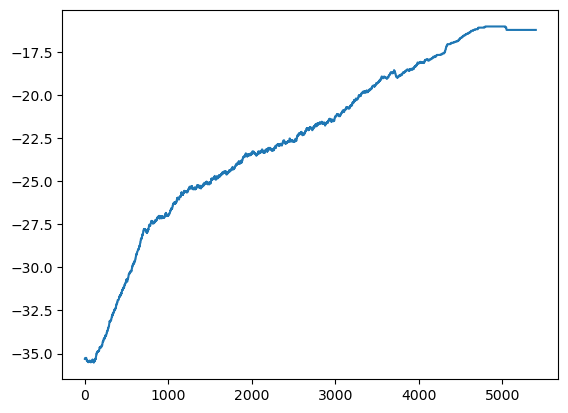

In [19]:
import matplotlib.pyplot as plt
plt.plot(y)